## **데이터 업로드**

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.stats import pointbiserialr
import re
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import matplotlib.pyplot as plt 
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': #맥os 사용자의 경우
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':#윈도우 사용자의 경우
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [85]:
#description 감정 분석 점수 column이 추가된 데이터 사용 (감정 분석 코드는 description_score 참조조)
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/메인 팀플 퀘스트/train_score.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/메인 팀플 퀘스트/test_score.csv')

train = train.drop('Unnamed: 0', axis = 1)
test = test.drop('Unnamed: 0', axis = 1)

train_2=train.copy()

## **0) 목적: 리뷰 평점 바탕 추천시스템**

> 그핵이는 '와인 마켓'을 운영하는데, 정교한 선호도를 바탕으로 유저들에게 평점이 높은 와인 순서대로 추천하고 싶다. 어떤 변수를 활용하면 가장 정확하게 평점을 예측해볼 수 있을까?

> 월 1회 프로모션 이벤트를 진행하고 싶은데, 어떤 컨셉(특정 지역, 특정 분류의 와인)으로 진행했을 때 구매 유도에 효과적일까?

## **1) EDA 및 데이터 파악**
  - 분포 확인
  - 결측치, 이상치 파악

In [6]:
train.head()

,country,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points
0,Australia,"Possibly a little sweet, this is a soft, easyg...",NaN,5.0,Australia Other,South Eastern Australia,NaN,Joe Czerwinski,@JoeCz,Banrock Station 2006 Chardonnay (South Eastern...,Chardonnay,Banrock Station,83
1,France,"A soft, almost off dry wine that is full in th...",Réserve,12.0,Rhône Valley,Côtes du Rhône,NaN,Roger Voss,@vossroger,Cellier des Dauphins 2015 Réserve Rosé (Côtes ...,Rosé,Cellier des Dauphins,85
2,Spain,Generic white-fruit aromas of peach and apple ...,Estate Grown & Bottled,9.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Esperanza 2013 Estate Grown & Bottled Verdejo-...,Verdejo-Viura,Esperanza,86
3,US,This is the winery's best Nebula in years. Whi...,Nebula,29.0,California,Paso Robles,Central Coast,NaN,NaN,Midnight 2010 Nebula Cabernet Sauvignon (Paso ...,Cabernet Sauvignon,Midnight,87
4,US,This is a very rich Pinot whose primary virtue...,Wiley Vineyard,40.0,California,Anderson Valley,NaN,NaN,NaN,Harrington 2006 Wiley Vineyard Pinot Noir (And...,Pinot Noir,Harrington,88


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103976 entries, 0 to 103975
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                103925 non-null  object 
 1   description            103976 non-null  object 
 2   designation            73967 non-null   object 
 3   price                  96781 non-null   float64
 4   province               103925 non-null  object 
 5   region_1               86954 non-null   object 
 6   region_2               40408 non-null   object 
 7   taster_name            83005 non-null   object 
 8   taster_twitter_handle  78994 non-null   object 
 9   title                  103976 non-null  object 
 10  variety                103975 non-null  object 
 11  winery                 103976 non-null  object 
 12  points                 103976 non-null  int64  
dtypes: float64(1), int64(1), object(11)
memory usage: 10.3+ MB


> 평가자의 주관적 평가(description)를 평가의 단어 개수(decription_count로) 대체

In [86]:
word_count_train = []
for i in range(len(train)):
  word_count_train.append(train.description[i].count(" ") + 1)

train['description_count'] = word_count_train

> Title 변수 안에 있는 Year 정보 추출

In [165]:
import re
title_lst_1 = train['title'].tolist()
year_list = []
for i in range(len(title_lst_1)):
    cnt = False
    string = title_lst_1[i]
    year = re.findall(r'\d+', string)
    if(len(year)==0):
        year_list.append('none')
    else:
        for j in range(len(year)):
            if(int(year[j])>=1980) and (int(year[j])<=2022):
                cnt = True
                tyear = year[j]
        if(cnt):
            year_list.append(tyear)
        else:
            year_list.append('none')
len(year_list)

103976

In [166]:
train['year'] = year_list

> 결측치 확인 및 이상치 확인

In [41]:
train.isnull().sum()/len(train)*100

Unnamed: 0                0.000000
country                   0.049050
description               0.000000
designation              28.861468
price                     6.919866
province                  0.049050
region_1                 16.371086
region_2                 61.137186
taster_name              20.169077
taster_twitter_handle    24.026698
title                     0.000000
variety                   0.000962
winery                    0.000000
points                    0.000000
tokens                    0.000000
description_score         0.000000
description_count         0.000000
year                      0.000000
dtype: float64

> 분포 확인

In [42]:
train.describe()

,Unnamed: 0,price,points,description_score,description_count
count,103976.000000,96781.000000,103976.000000,103976.000000,103976.000000
mean,51987.500000,35.437410,88.448575,87.284986,40.370335
std,30015.430132,42.425377,3.040322,27.645550,11.088885
min,0.000000,4.000000,80.000000,0.000000,3.000000
25%,25993.750000,17.000000,86.000000,67.920000,33.000000
50%,51987.500000,25.000000,88.000000,85.180000,39.000000
75%,77981.250000,42.000000,91.000000,104.280000,47.000000
max,103975.000000,3300.000000,100.000000,276.670000,127.000000


skewness: -0.242731
kurtosis: -0.159566


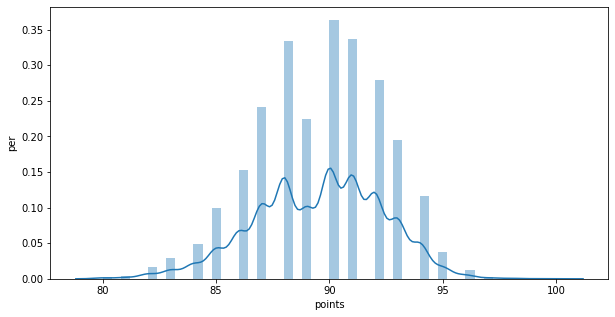

In [167]:
#points
plt.figure(figsize = (10,5))
train_eda = train.dropna(axis = 0)

price = sns.distplot(train_eda['points'])
price.set_xlabel('points')
price.set_ylabel('per')
plt.show

print('skewness: %f' % train_eda['points'].skew()) 
print('kurtosis: %f' % train_eda['points'].kurt()) 

skewness: 0.353648
kurtosis: 0.201598


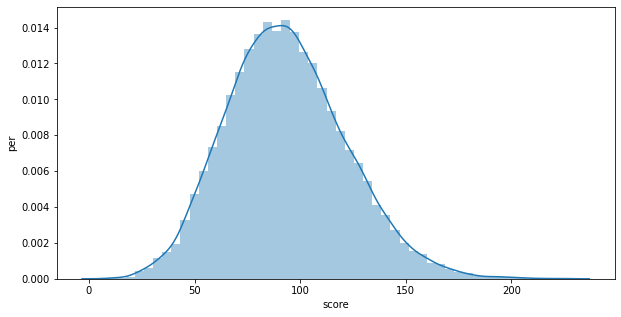

In [46]:
#description_score
plt.figure(figsize = (10,5))
train_eda = train.dropna(axis = 0)

price = sns.distplot(train_eda['description_score'])
price.set_xlabel('score')
price.set_ylabel('per')
plt.show

print('skewness: %f' % train_eda['description_score'].skew()) 
print('kurtosis: %f' % train_eda['description_score'].kurt()) 

skewness: 0.305375
kurtosis: 0.353028


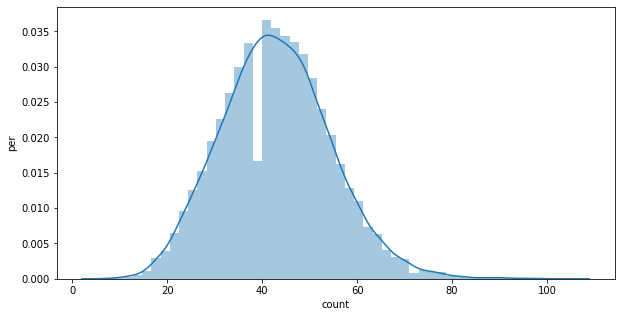

In [90]:
#description_count
plt.figure(figsize = (10,5))
train_eda = train.dropna(axis = 0)

price = sns.distplot(train_eda['description_count'])
price.set_xlabel('count')
price.set_ylabel('per')
plt.show

print('skewness: %f' % train_eda['description_count'].skew()) 
print('kurtosis: %f' % train_eda['description_count'].kurt()) 

skewness: 18.443796
kurtosis: 1054.585693


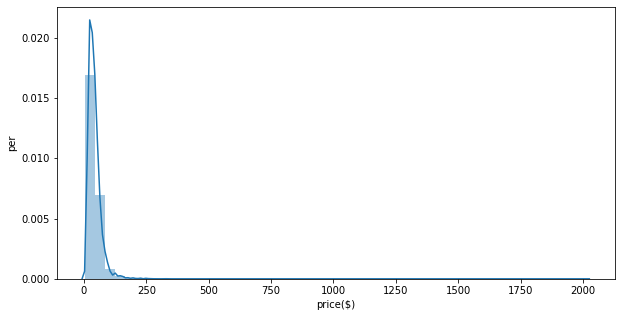

In [45]:
#price
plt.figure(figsize = (10,5))
train_eda = train.dropna(axis = 0)

price = sns.distplot(train_eda['price'])
price.set_xlabel('price($)')
price.set_ylabel('per')
plt.show

print('skewness: %f' % train_eda['price'].skew()) 
print('kurtosis: %f' % train_eda['price'].kurt()) 

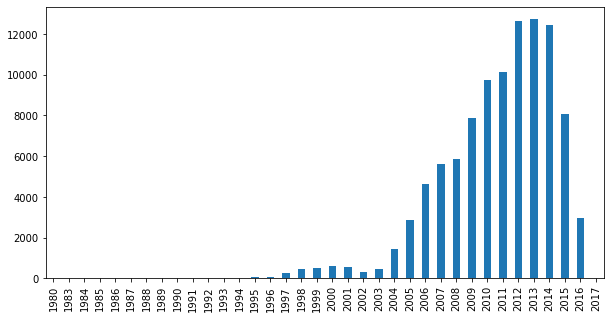

In [111]:
#year
train_yeardrop = train.drop(index=train.loc[train.year == 'none'].index)
train_yeardrop['year'] = train_yeardrop['year'].astype(int)
plt.figure(figsize=(10,5))
train_yeardrop['year'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show()

## **2) 데이터 시각화**

> 결측치 처리

In [91]:
train.isnull().sum()/len(train) *100
## 열 제거(활용하지 않을 변수): designation, region_1, region_2, taster_twitter_handle
## 행 제거: country, variety, province
## 'None'값 대체: taster_name
## mean 값 대체: price

country                   0.049050
description               0.000000
designation              28.861468
price                     6.919866
province                  0.049050
region_1                 16.371086
region_2                 61.137186
taster_name              20.169077
taster_twitter_handle    24.026698
title                     0.000000
variety                   0.000962
winery                    0.000000
points                    0.000000
tokens                    0.000000
description_score         0.000000
description_count         0.000000
year                      0.000000
dtype: float64

> train, validation, test set 분리

In [168]:
train1 = train.drop(['designation', 'region_1', 'region_2', 'taster_twitter_handle'], axis = 1)
train1['taster_name'] = train['taster_name'].fillna('None')
train1['price'] = train1['price'].fillna(train1['price'].mean())
train_final = train1.dropna(axis = 0)

In [169]:
y = train_final['points']
X_train, X_valid, y_train, y_valid = train_test_split(train_final, y, train_size=0.8, test_size=0.2, random_state=0)

> price 이상치 처리

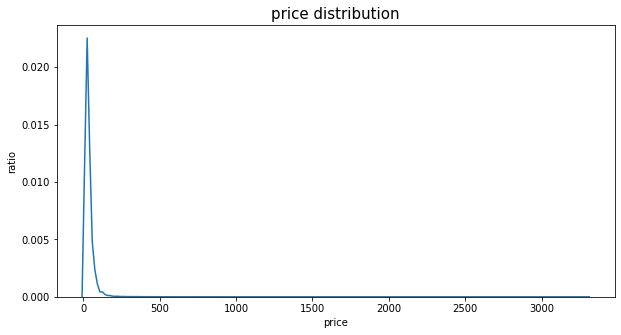

In [94]:
price = X_train.price
plt.figure(figsize=(10,5))
sns.kdeplot(price)
plt.xlabel('price')
plt.ylabel('ratio')
plt.title('price distribution',fontsize=15)
plt.savefig('price_kdeplot.png')
plt.show()

In [95]:
price_cut = price[price < price.quantile(0.99)]  # td값 중 상위 1%를 이상치로 간주해 제거

print('원래 data 개수:', len(price)) 
print('이상치 제거 후 data 개수:', len(price_cut))  # 총 7만 2천개에서 6만 8천개를 관심 있는 모집단으로 한정

원래 data 개수: 83139
이상치 제거 후 data 개수: 82198


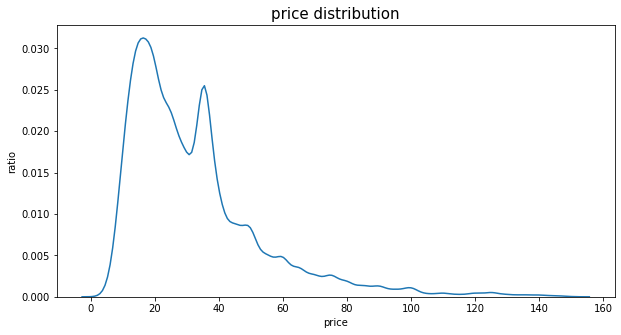

In [96]:
plt.figure(figsize=(10,5))
snskde = sns.kdeplot(price_cut)
plt.xlabel('price')
plt.ylabel('ratio')
plt.title('price distribution',fontsize=15)
plt.savefig('price_cut_kdeplot.png')
plt.show()

In [97]:
X_train_cut = X_train.drop(index = X_train.loc[X_train.price > X_train.price.quantile(0.99)].index)

> 상관관계 확인

In [98]:
X_train_cut.corr()

,price,points,description_score,description_count
price,1.000000,0.526195,0.273580,0.304058
points,0.526195,1.000000,0.455169,0.514931
description_score,0.273580,0.455169,1.000000,0.787540
description_count,0.304058,0.514931,0.787540,1.000000


> **가설 수립**

1. 가격대가 있는 와인은 높은 점수를 받았을 것이다. (기대 심리 반영)

2. Taster마다 점수를 부여하는 스케일이 서로 다를 것이다.

3. 와인 품질은 특정 ‘연도’에 특정 ‘지역’에서 수확한 포도 ‘품종’의 영향을 받을 것이다. 
(by 도메인 지식)

4. 문장 길이가 길면서 정성스러운 Description일수록 긍정적인 평가일 것이다.


> Price(가설1) 

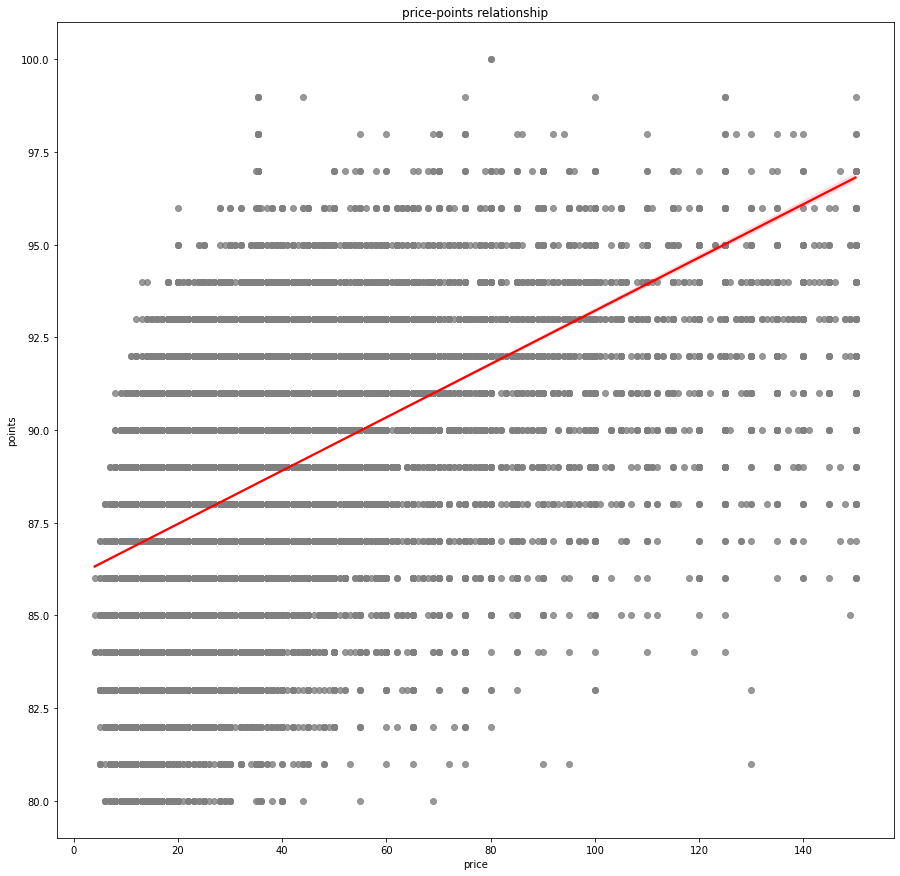

In [100]:
plt.figure(figsize = (15,15))
sns.regplot(x='price', y='points', data=X_train_cut,
             line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
plt.title('price-points relationship')
plt.xlabel('price')
plt.ylabel('points')
plt.savefig('price-points_total.png')
plt.show()

In [102]:
RANDOM_SEED = 1023
np.random.seed(RANDOM_SEED)

train_rand_1000 = X_train_cut.sample(n=1000)
train_rand_1000

,country,description,price,province,taster_name,title,variety,winery,points,tokens,description_score,description_count,year
61238,Germany,Earthy aromas at the outset subside to reveal ...,40.00000,Mosel,Anna Lee C. Iijima,Dr. Hermann 2012 Erdener Treppchen Herzlay Spä...,Riesling,Dr. Hermann,92,"['earthy', 'aromas', 'outset', 'subside', 'rev...",82.50,56,2012
100604,US,A red Meritage driven by 73% Cabernet Sauvigno...,50.00000,California,Virginie Boone,Franciscan 2012 Magnificat Meritage (Napa Valley),Meritage,Franciscan,91,"['red', 'meritage', 'driven', 'cabernet', 'sau...",77.86,44,2012
52838,France,"This is a powerful wine, full of dark fruits a...",24.00000,Southwest France,Roger Voss,Château Haut-Monplaisir 2012 Prestige Malbec (...,Malbec,Château Haut-Monplaisir,93,"['powerful', 'wine', 'full', 'dark', 'fruits',...",102.78,45,2012
64158,France,"Light and fruity, this is full of strawberries...",12.00000,Beaujolais,Roger Voss,Château de Pizay 2014 Rosé de Soirée Rosé (Bea...,Rosé,Château de Pizay,84,"['light', 'fruity', 'full', 'strawberries', 'w...",78.08,29,2014
6796,France,"This 12-acre estate has produced a ripe, fruit...",35.43741,Bordeaux,Roger Voss,Château Lamour 2012 Castillon Côtes de Bordeaux,Bordeaux-style Red Blend,Château Lamour,87,"['acre', 'estate', 'produced', 'ripe', 'fruity...",66.05,34,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98582,France,"87-89 Very cassis in character, with fruit, so...",35.43741,Bordeaux,Roger Voss,Château Simard 2010 Barrel sample (Saint-Émil...,Bordeaux-style Red Blend,Château Simard,88,"['cassis', 'character', 'fruit', 'weight', 'to...",30.61,13,2010
93329,Portugal,"A very aromatic, violet-perfumed wine. It has ...",16.00000,Lisboa,Roger Voss,Quinta da Cortezia 2008 Reserva Touriga Nacion...,Touriga Nacional,Quinta da Cortezia,90,"['aromatic', 'violet', 'perfumed', 'wine', 'st...",52.26,21,2008
62826,Spain,"Roasted, smoky, earthy aromas of herbal berry ...",10.00000,Catalonia,Michael Schachner,Pinord 2010 Clos de Torribas Crianza Tempranil...,Tempranillo,Pinord,86,"['roasted', 'smoky', 'earthy', 'aromas', 'herb...",82.07,42,2010
39432,Italy,"Oak, vanilla, toast and espresso aromas lead t...",30.00000,Piedmont,Kerin O’Keefe,Marco Bonfante 2012 Barolo,Nebbiolo,Marco Bonfante,86,"['oak', 'vanilla', 'toast', 'espresso', 'aroma...",91.58,39,2012


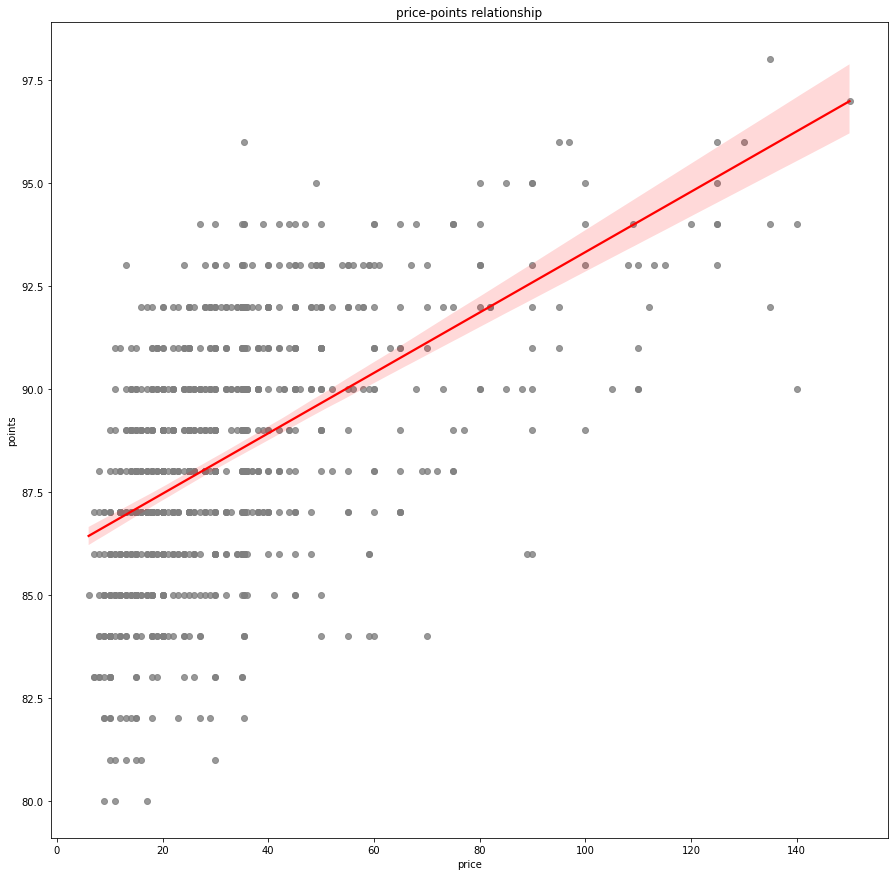

In [103]:
plt.figure(figsize = (15,15))
sns.regplot(x='price', y='points', data=train_rand_1000,
             line_kws={'color': 'red'}, scatter_kws={'color': 'grey'})
plt.title('price-points relationship')
plt.xlabel('price')
plt.ylabel('points')
plt.savefig('price-points.png')
plt.show()

> taster_name(가설2) 

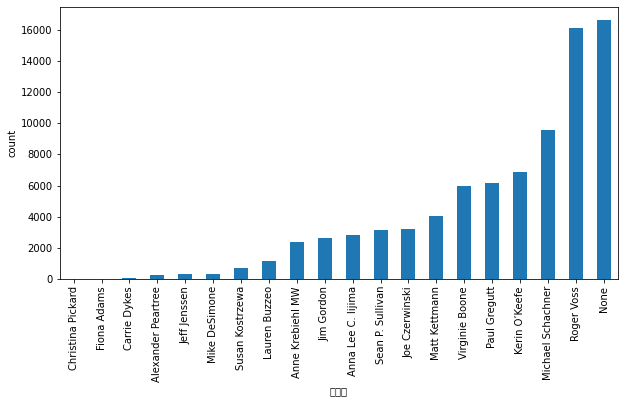

In [114]:
plt.figure(figsize=(10,5))

X_train_cut['taster_name'].value_counts(ascending=True).plot(kind='bar') # default=False
plt.xlabel('평가자')
plt.ylabel('count')
plt.show() 

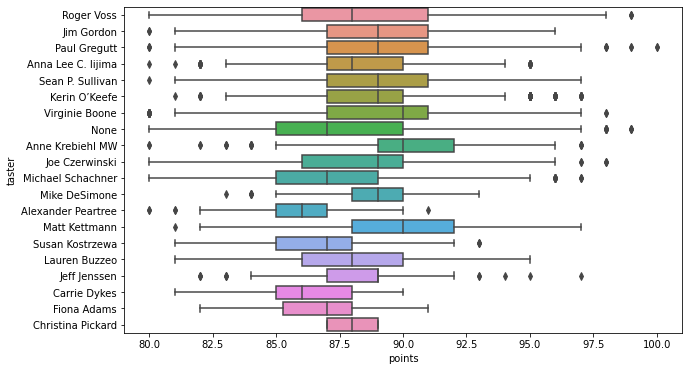

In [116]:
plt.figure(figsize=(10,6))
box = sns.boxplot(x='points', y='taster_name', data=X_train_cut)
box.set_ylabel("taster")
box.set_xlabel("points")
plt.show()

In [ ]:
##anova:평가자들의 점수가 다를까?

In [126]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats

In [118]:
points_Matt = X_train_cut[X_train_cut['taster_name']=='Matt Kettmann'].points
points_Anna = X_train_cut[X_train_cut['taster_name'] == 'Anna Lee C. Iijima'].points
points_Alex = X_train_cut[X_train_cut['taster_name']=='Alexander Peartree'].points

In [119]:
avg_Matt = points_Matt.mean()
std_Matt = points_Matt.std()

print('Matt 평균:',round(avg_Matt, 3), '/ Matt 표준편차:', round(std_Matt, 3))

avg_Anna = points_Anna.mean()
std_Anna = points_Anna.std()

print('Anna 평균:',round(avg_Anna, 3), '/ Anna 표준편차:', round(std_Anna, 3))

avg_Alex = points_Alex.mean()
std_Alex = points_Alex.std()

print('Alex 평균:',round(avg_Alex, 3), '/ Alex 표준편차:', round(std_Alex, 3))

Matt 평균: 90.053 / Matt 표준편차: 2.569
Anna 평균: 88.35 / Anna 표준편차: 2.488
Alex 평균: 85.878 / Alex 표준편차: 1.886


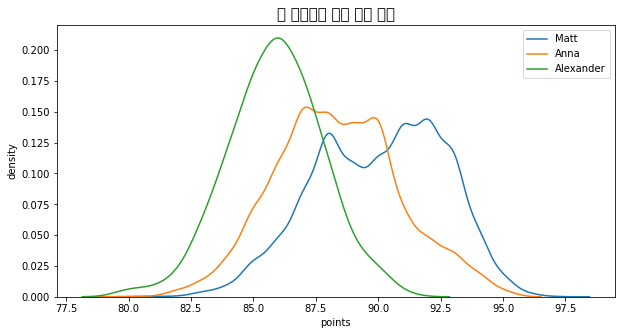

In [120]:
plt.figure(figsize=(10,5))
sns.kdeplot(points_Matt)
sns.kdeplot(points_Anna)
sns.kdeplot(points_Alex)
plt.xlabel("points")
plt.ylabel('density')
plt.legend(['Matt','Anna','Alexander'])
plt.title('세 평가자의 평균 점수 비교', fontsize=15)
plt.show() 

In [121]:
print("Matt Skewness: %.3f" % points_Matt.skew())  
print("Matt Kurtosis: %.3f" % points_Matt.kurt())

print("Anna Skewness: %.3f" % points_Anna.skew())  
print("Anna Kurtosis: %.3f" % points_Anna.kurt())

print("Alex Skewness: %.3f" % points_Alex.skew())  
print("Alex Kurtosis: %.3f" % points_Alex.kurt())

Matt Skewness: -0.247
Matt Kurtosis: -0.593
Anna Skewness: 0.140
Anna Kurtosis: -0.188
Alex Skewness: -0.153
Alex Kurtosis: 0.262


In [122]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
grp_Matt = np.random.choice(points_Matt, 50)
np.random.seed(RANDOM_SEED+5)
grp_Anna = np.random.choice(points_Anna, 50)
np.random.seed(RANDOM_SEED+10)
grp_Alex = np.random.choice(points_Alex, 50)

In [128]:
equal_var_pval = stats.levene(grp_Matt, grp_Anna, grp_Alex)[1]
print('등분산 검정의 p-value는',round(equal_var_pval, 3))

등분산 검정의 p-value는 0.001


In [129]:
df_Matt = pd.DataFrame(grp_Matt).rename(columns={0:'points'})
df_Matt['taster_name'] = 'Matt Kettmann'
df_Anna = pd.DataFrame(grp_Anna).rename(columns={0:'points'})
df_Anna['taster_name'] = 'Anna Lee C. Iijima'
df_Alex = pd.DataFrame(grp_Alex).rename(columns={0:'points'})
df_Alex['taster_name'] = 'Alexander Peartree'

data = pd.concat([df_Matt, df_Anna, df_Alex])
data.head()

,points,taster_name
0,88,Matt Kettmann
1,85,Matt Kettmann
2,91,Matt Kettmann
3,93,Matt Kettmann
4,92,Matt Kettmann


In [130]:
#등분산성 위배로 Welch's Anova 실행행
import pingouin as pg
pg.welch_anova(dv='points', between='taster_name', data=data)

,Source,ddof1,ddof2,F,p-unc,np2
0,taster_name,2,93.673109,29.308154,1.302929e-10,0.246829


> Year & variety (가설3) 

In [106]:
province_top10 = X_train_cut.groupby('province').size().reset_index(name = 'n').sort_values('n', ascending = False).reset_index(drop = True).head(10)
#california, bordeaux, Tuscany로 변인 통제

In [107]:
index_province = X_train_cut[~(X_train_cut['province'].isin(list(province_top10['province'])))].index
df_province = X_train_cut.drop(index_province)

In [108]:
df_california = df_province[df_province['province'] == 'California']
df_bordeaux = df_province[df_province['province'] == 'Bordeaux']
df_tuscany = df_province[df_province['province'] == 'Tuscany']

In [112]:
california_top10variety = df_california.groupby('variety').size().reset_index(name = 'n').sort_values('n', ascending  = False).reset_index(drop = True).head(10)
bordeaux_top10variety = df_bordeaux.groupby('variety').size().reset_index(name = 'n').sort_values('n', ascending  = False).reset_index(drop = True).head(10)
tuscany_top10variety = df_tuscany.groupby('variety').size().reset_index(name = 'n').sort_values('n', ascending  = False).reset_index(drop = True).head(10)


cali_top10variety_index = df_province[~(df_province['variety'].isin(list(california_top10variety['variety'])))].index
cali_top10variety = df_province.drop(cali_top10variety_index)
cali_top10variety = cali_top10variety.drop(index=cali_top10variety.loc[cali_top10variety.year == 'none'].index)
cali_top10variety['year'] = cali_top10variety['year'].astype(int)


bordeaux_top10variety_index = df_province[~(df_province['variety'].isin(list(bordeaux_top10variety['variety'])))].index
bordeaux_top10variety = df_province.drop(bordeaux_top10variety_index)
bordeaux_top10variety = bordeaux_top10variety.drop(index=bordeaux_top10variety.loc[bordeaux_top10variety.year == 'none'].index)
bordeaux_top10variety['year'] = bordeaux_top10variety['year'].astype(int)


tus_top10variety_index = df_province[~(df_province['variety'].isin(list(tuscany_top10variety['variety'])))].index
tus_top10variety = df_province.drop(tus_top10variety_index)
tus_top10variety = tus_top10variety.drop(index=tus_top10variety.loc[tus_top10variety.year == 'none'].index)
tus_top10variety['year'] = tus_top10variety['year'].astype(int)

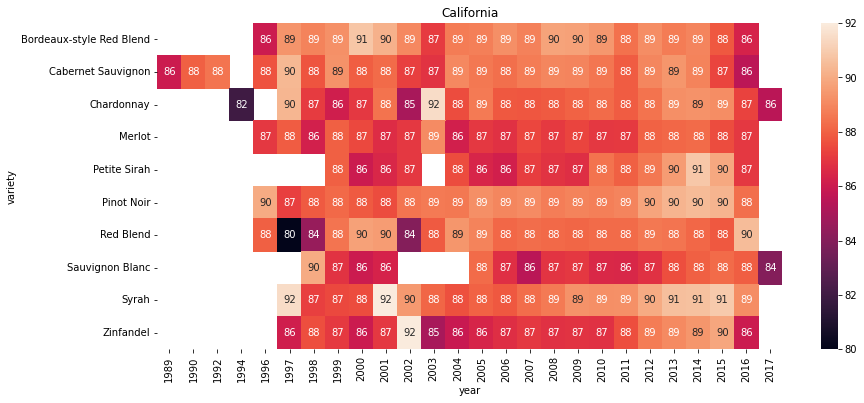

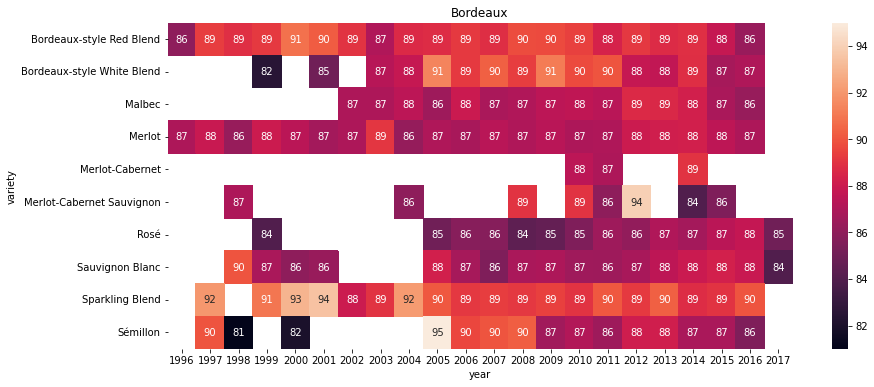

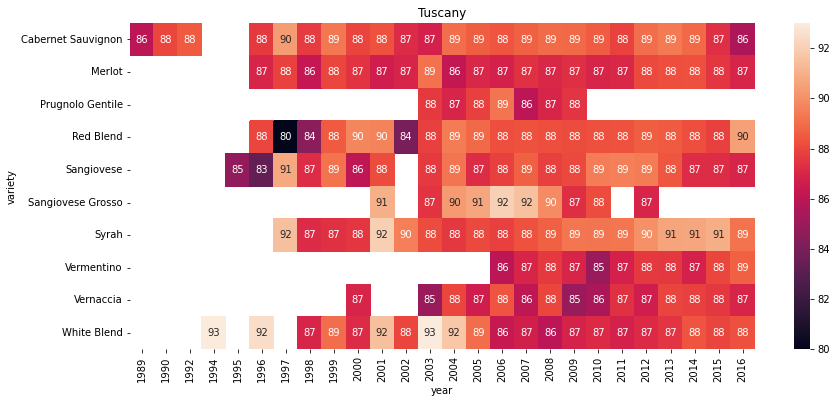

In [113]:
cali_pivot_v = pd.pivot_table(cali_top10variety, values = 'points', index = ['variety'], columns = ['year'])
bord_pivot_v = pd.pivot_table(bordeaux_top10variety, values = 'points', index = ['variety'], columns = ['year'])
tus_pivot_v = pd.pivot_table(tus_top10variety, values = 'points', index = ['variety'], columns = ['year'])


plt.figure(figsize=(14,6))
sns.heatmap(cali_pivot_v, annot=True)
plt.title('California')
plt.savefig('califorania_year_variety')
plt.show()

plt.figure(figsize=(14,6))
sns.heatmap(bord_pivot_v, annot=True)
plt.title('Bordeaux')
plt.savefig('bordeaux_year_variety')
plt.show()


plt.figure(figsize=(14,6))
sns.heatmap(tus_pivot_v, annot=True)
plt.title('Tuscany')
plt.savefig('tuscany_year_variety')
plt.show()

> Description_score(가설4) 

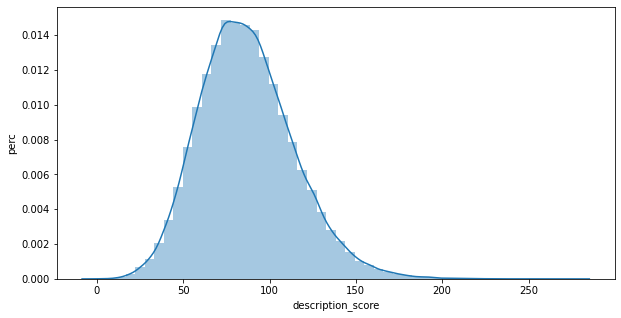

Skewness: 0.493720
Kurtosis: 0.554919


In [134]:
plt.figure(figsize=(10,5))

dist = sns.distplot(X_train_cut['description_score']) 
dist.set_xlabel("description_score")
dist.set_ylabel("perc")
plt.show()

print("Skewness: %f" % X_train_cut['description_score'].skew()) # 왜도
print("Kurtosis: %f" % X_train_cut['description_score'].kurt()) # 첨도

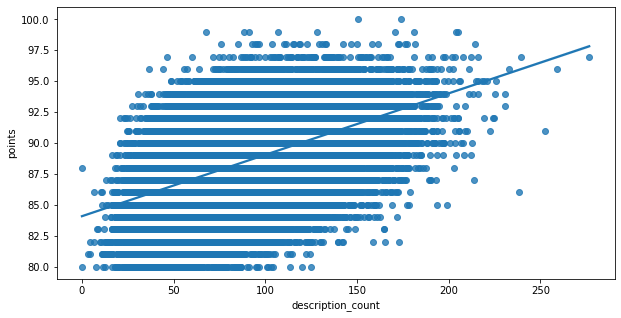

In [135]:
plt.figure(figsize=(10,5))
sns.regplot(data=X_train_cut, x='description_score', y='points')
plt.xlabel('description_count') # x축 제목
plt.ylabel('points') # y축 제목
plt.show()

## **3) 데이터 전처리**

> Categorical 데이터 전처리 (One-hot-encoding)

In [171]:
feature_columns = ['province', 'year', 'variety', 'price', 'taster_name']

In [170]:
import re
title_lst_2 = test['title'].tolist()
year_list = []
for i in range(len(title_lst_2)):
    cnt = False
    string = title_lst_2[i]
    year = re.findall(r'\d+', string)
    if(len(year)==0):
        year_list.append('none')
    else:
        for j in range(len(year)):
            if(int(year[j])>=1980) and (int(year[j])<=2022):
                cnt = True
                tyear = year[j]
        if(cnt):
            year_list.append(tyear)
        else:
            year_list.append('none')
len(year_list)

25995

In [172]:
test['year'] = year_list

In [173]:
X_train = X_train[feature_columns]
X_valid = X_valid[feature_columns]
X_test = test.copy()
X_test = X_test[feature_columns]

In [174]:
feature_columns_categorical = ['taster_name', 'year','province','variety']

# categorical field의 NaN 값을 모두 'None'이라는 string으로 바꿔줍니다.
X_train[feature_columns_categorical] = X_train[feature_columns_categorical].fillna('None')
X_valid[feature_columns_categorical] = X_valid[feature_columns_categorical].fillna('None')
X_test[feature_columns_categorical] = X_test[feature_columns_categorical].fillna('None')

In [175]:
print(len(X_train['taster_name'].unique())) # 20 unique provinces
print(len(X_train['year'].unique())) # 35 unique variety
print(len(X_train['province'].unique())) # 396 unique variety
print(len(X_train['variety'].unique())) # 639 unique variety

20
35
396
639


In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83139 entries, 9943 to 68303
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   province     83139 non-null  object 
 1   year         83139 non-null  object 
 2   variety      83139 non-null  object 
 3   price        83139 non-null  float64
 4   taster_name  83139 non-null  object 
dtypes: float64(1), object(4)
memory usage: 5.8+ MB


In [176]:
from sklearn.preprocessing import OneHotEncoder

cate_columns = ['province','year','variety', 'taster_name']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[cate_columns]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[cate_columns]))

OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

OH_cols_train.columns = OH_encoder.get_feature_names(['province','year','variety', 'taster_name'])
OH_cols_valid.columns = OH_encoder.get_feature_names(['province','year','variety', 'taster_name'])

In [179]:
num_X_train = X_train.drop(cate_columns, axis=1)
num_X_valid = X_valid.drop(cate_columns, axis=1)

In [180]:
preprocessed_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
preprocessed_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

## **4) 모델링**

> Decision Tree

In [181]:
model = DecisionTreeRegressor(random_state=1, max_depth=12)
model.fit(preprocessed_X_train, y_train)
valid_preds = model.predict(preprocessed_X_valid)
print('RMSE: {}'.format(mean_squared_error(y_valid, valid_preds, squared=False)))
print('R2: {}'.format(r2_score(y_valid, valid_preds)))

RMSE: 2.323493819767242
R2: 0.41887044654210925


> Random Forest

In [199]:
model_rf = RandomForestRegressor(n_estimators=100,
                                    max_depth=None, max_features='auto',
                                    oob_score=False, random_state=531)
model_rf.fit(preprocessed_X_train, y_train)
valid_preds = model_rf.predict(preprocessed_X_valid)
print('RMSE: {}'.format(mean_squared_error(y_valid, valid_preds, squared=False)))
print('R2: {}'.format(r2_score(y_valid, valid_preds)))

RMSE: 2.3020732254609344
R2: 0.42953607412328376


> Light GBM

In [183]:
import lightgbm as lgb

In [184]:
X_train_lg = preprocessed_X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_valid_lg = preprocessed_X_valid.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [185]:
train_ds = lgb.Dataset(X_train_lg, label = y_train)
valid_ds = lgb.Dataset(X_valid_lg, label =y_valid)

In [186]:
params = {'learning_rate':0.01, 
          'max_depth':16, 
          'boosting':'gbdt',
          'objective':'regression', 
          'metric':'rmse', 
          'is_training_metric':True, 
          'num_leaves' : 144, 
          'feature_fraction' : 0.7, 
          'bagging_fraction' : 0.7, 'bagging_freq' : 5, 
          'seed' : 2022
         }

In [187]:
model_lgbm = lgb.train(params, train_ds, 1000, valid_ds, verbose_eval=100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.44586
[200]	valid_0's rmse: 2.28364
[300]	valid_0's rmse: 2.23616
[400]	valid_0's rmse: 2.21786
[500]	valid_0's rmse: 2.20863
[600]	valid_0's rmse: 2.20283
[700]	valid_0's rmse: 2.19853
[800]	valid_0's rmse: 2.19479
[900]	valid_0's rmse: 2.19174
[1000]	valid_0's rmse: 2.18936
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.18936


In [188]:
valid_preds_lgbm = model_lgbm.predict(preprocessed_X_valid)
print('RMSE: {}'.format(mean_squared_error(y_valid, valid_preds_lgbm, squared=False)))
print('MAE: {}'.format(mean_absolute_error(y_valid, valid_preds_lgbm)))
print('R2 Score: {}'.format(r2_score(y_valid, valid_preds_lgbm)))

RMSE: 2.189358927337826
MAE: 1.7150000848018203
R2 Score: 0.4840307123156209


## **5) Test set 예측**

In [191]:
X_test.isnull().sum()/len(X_test)

province       0.000000
year           0.000000
variety        0.000000
price          0.069283
taster_name    0.000000
dtype: float64

In [193]:
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[cate_columns]))
OH_cols_test.index = X_test.index
num_X_test = X_test.drop(cate_columns, axis=1)
my_imputer = SimpleImputer(strategy='mean')
imputed_num_X_test = pd.DataFrame(my_imputer.fit_transform(num_X_test))
imputed_num_X_test.index = num_X_test.index

preprocessed_X_test = pd.concat([imputed_num_X_test, OH_cols_test], axis=1)
test_preds = model_lgbm.predict(preprocessed_X_test)

In [194]:
my_submission = pd.DataFrame({'id': preprocessed_X_test.index, 'points': test_preds})
my_submission.to_csv('wine_my_submission.csv', index=False)

In [196]:
final = test.copy()
final['points'] = my_submission['points']
score = final.points.nlargest(10).tolist()

In [197]:
title_lst = []
for i in score:
    title_lst.append(final[final['points']==i].title.to_string())

In [198]:
title_lst

['727    Château Ausone 2014  Saint-Émilion',
 '12119    Domaine Leflaive 2010  Bâtard-Montrachet',
 '8169    Olivier Leflaive 2014  Bâtard-Montrachet',
 '25243    Louis Latour 2015 Les Quatre Journaux  (Romané...',
 '2635    Château Mouton Rothschild 2014  Pauillac',
 '3472    Domaine Leflaive 2006  Chevalier-Montrachet',
 '7150    Château Lafite Rothschild 2010  Pauillac',
 '20833    Verité 2008 Le Desir Red (Sonoma County)',
 '4428    Henschke 2010 Hill of Grace Shiraz (Eden Valley)',
 '14303    Penfolds 2008 Grange Shiraz (South Australia)']